# Instrucciones.

En el laboratorio realice las siguientes tareas

* Complete la celda "A. Datos grupo".
* Descargue los archivos de instancias de ucursos.
* Complete la sección "B. preparación"
* Lea el enunciado y complete los ejercicios 1, 2 y 3.
* Envie el archivo .ipynb por el modulo de tareas de ucursos en la TAREA: Laboratorio 2 presencial 
* Plazo de entrega:  Miércoles 6 de mayo las 18:00

La parte no presencial del laboratorio corresponde a los ejercicios 4, 5 y 6.
Se recomienda realizar esta parte durante el laboratorio, pero tiene tiempo de entrega hasta el día Viernes 8 de mayo a las 22:00

* Complete todos los ejercicios
* Envie el archivo .ipynb por el modulo de tareas de ucursos en la TAREA: Laboratorio 2 completo
* Plazo de entrega: Viernes 8 de mayo a las 22:00 
  (puede solicitar por correo electrónico plazo adicional si lo necesita, pero su solicitud debe hacerse antes del Viernes 8 a    las 22:00. No es automático)


# A. Datos grupo

Escriba en esta celda el nombre de cada integrante de su grupo.

- Integrante 1: XXX

- Integrante 2: YYY

# B. Preparación

* Usaremos los paquetes JuMP, Gurobi, Distances y Plots.
  Descomente las lineas si no tiene los paquetes y asegúrese de tener la última versión de JuMP corriendo (0.21.2 en mayo 2020)

In [1]:
import Pkg
#Pkg.add("Distances")
#Pkg.add("Plots")
#Pkg.update("JuMP")
Pkg.status("JuMP")

     Status `~/.juliapro/JuliaPro_v1.3.1-1/environments/v1.3/Project.toml`
   4076af6c JuMP v0.21.2 `https://github.com/JuliaOpt/JuMP.jl/#master`


In [2]:
using JuMP, Gurobi, Distances, Plots
const GUROBI_ENV = Gurobi.Env() #Esta referencia  nos servirá para usar solo un ambiente de Gurobi.

Academic license - for non-commercial use only


Gurobi.Env(Ptr{Nothing} @0x0000000005249c70)

* En este problema calcularemos tours que pasan por ciudades en el plano, para cargar los archivos de entrada y visualizar estos tours usaremos algunas funciones pre-escritas. El archivo "preparacion.jl", escrito a continuación, tiene las funciones que necesitaremos.

```julia
dibuja(coordx,coordy,arcos)
## Recibe dos arreglos de N valores donde (coordx[i],coordy[i]) son las coordenadas de la ciudad i
## Recibe además una matriz arcos de N x N, donde arcos[i,j] es el peso del arco [i,j]
## Dibuja los N puntos en el plano y dibuja los arcos con ancho de linea proporcional al peso.

lee_archivo(nombre_archivo)
## Recibe un archivo con las coordenadas de N ciudades, devolviendo N, las coordenadas x, las coordenadas y.

encuentra_ciclo(arcos)
#Si arcos es una matriz 0-1 (o cercana a serlo) tal que el nodo 1 está en un único ciclo, esta función lo reporta.
```

* Cargue el archivo usando el siguiente comando.

In [3]:
include("preparacion.jl");

* Pruebe las funciones auxiliares cargando el archivo "ejemplo.txt" (con 25 puntos), y dandole peso a algunas aristas como sigue:

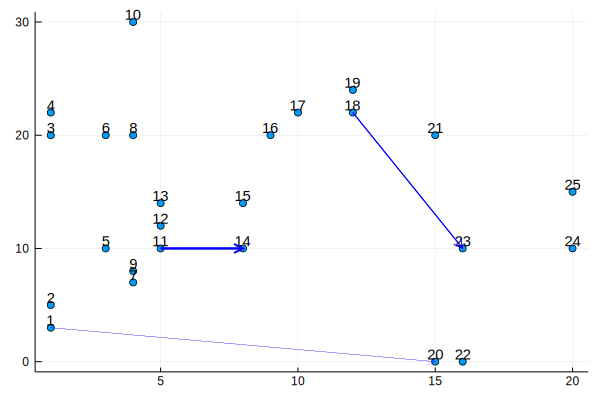

In [4]:
N,x_pos,y_pos=lee_archivo("ejemplo.txt")
aristas_ejemplo=zeros(N,N)
aristas_ejemplo[11,14]=1
aristas_ejemplo[1,20]=0.1
aristas_ejemplo[18,23]=0.5
dibuja(x_pos,y_pos,aristas_ejemplo)

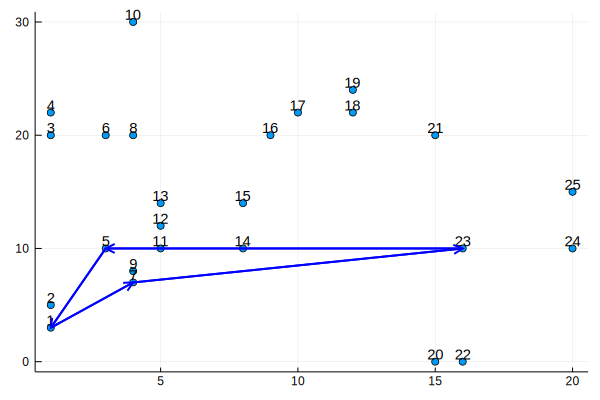

4-element Array{Int64,1}:
  1
  7
 23
  5

In [5]:
ciclo_ejemplo=zeros(N,N)
ciclo_ejemplo[1,7]=1
ciclo_ejemplo[7,23]=1
ciclo_ejemplo[23,5]=1
ciclo_ejemplo[5,1]=1
dibuja(x_pos,y_pos,ciclo_ejemplo)
encuentra_ciclo(ciclo_ejemplo)

# C. MTZ para el problema del vendedor viajero.

En el problema del vendedor viajero (TSP), recibimos N ciudades del plano y deseamos encontrar un tour (ciclo) que pase por cada punto exactamente una vez, de largo total mínimo. Este problema es NP-completo y difícil de abordar en toda generalidad.
En este laboratorio describiremos un programa entero de tamaño exponencial (en N) para resolver TSP, y luego usaremos técnicas de generación de filas para resolver este problema.

Hay *varias* formas de modelar TSP como PLE, algunas de ellas tienen tamaño polinomial. Para esto supondremos que $d(i,j)$ es la distancia del punto $i$ al punto $j$ y $z_{i,j}$ es la indicatriz del arco $(i,j)$ en el tour.

Por ejemplo, el siguiente modelo conocido como MTZ (Miller, Tucker, Zemlin) tiene "solo" $O(N^2)$ variables y restricciones.
(La variable $u_i$ representa la manera el orden en el cual son visitados los nodos).

\begin{align*}
(\text{MTZ})\qquad \min \sum_{i=1}^N\sum_{j=1}^N z_{i,j}d(i,j)&\\
z_{i,i}&=0,&\forall i\in [N]\\
\sum_{j=1}^N z_{i,j} &= 1,& \forall i\in [N]\\
\sum_{j=1}^N z_{j,i} &= 1,&\forall i\in [N]\\
u_i−u_j+(N−1)z_{i,j}&\leq N−2, &\forall i,j \in [N], i\geq 2, j\geq 2\\
z &\in \{0,1\}^{[N]\times [N]}\\
u&\in \mathbb{R}^{[N]\setminus \{1\}}
\end{align*}

Sin embargo, en la práctica no es muy efectivo. Para 25 ciudades ya toma algunos segundos como se ve a continuación.
Para grandes cantidades de ciudades se vuelve muy lento pues la formulación está muy lejos de ser exacta.

Al principio del laboratorio probemos el modelo MTZ (nos servirá para recordar como se escribe un PLM)

In [6]:
function resuelveMTZ(nombre_archivo)
## Resuelve MTZ, devuelve el valor, el ciclo, y dibuja la solución
  
    #Cargar datos del archivo
    N,x_pos,y_pos = lee_archivo(nombre_archivo)

    #Crear un modelo nuevo. 
    #la variable GUROBI_ENV creada en el archivo preparación nos permite reutilizar el ambiente de Gurobi
    #en vez de crear uno nuevo cada vez que creamos un modelo (en particular, ya no saldrán múltiples
    #mensajes sobre la licencia académica)
    #(esta sintaxis se usa a partir de Jump 0.21)
    MTZ = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 1))

    #Crear variables, z es binaria, u es real.
    @variable(MTZ, z[1:N,1:N], Bin)
    @variable(MTZ, u[2:N])

    #Crear objetivo (usamos "euclidean" del paquete Distances para calcular la distancia euclideana)
    @objective(MTZ, Min, sum(z[i,j]*euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]]) for i=1:N,j=1:N))

    #Crear restricciones
    @constraints(MTZ, begin
        self[i=1:N], z[i,i]==0
        salida[i=1:N], sum(z[i,1:N])==1
        entrada[i=1:N], sum(z[1:N,i])==1
        prioridad[i=2:N, j=2:N], u[i]-u[j]+N*z[i,j]<=N-1
    end)
    
    #optimizar! (el modelo es siempre factible)
    optimize!(MTZ)
    
    #dibuja y retorna
    valor =  objective_value(MTZ)
    vector = value.(z) 
    ciclo = encuentra_ciclo(vector)
    dibuja(x_pos,y_pos,vector)
    return valor, ciclo
end

resuelveMTZ (generic function with 1 method)

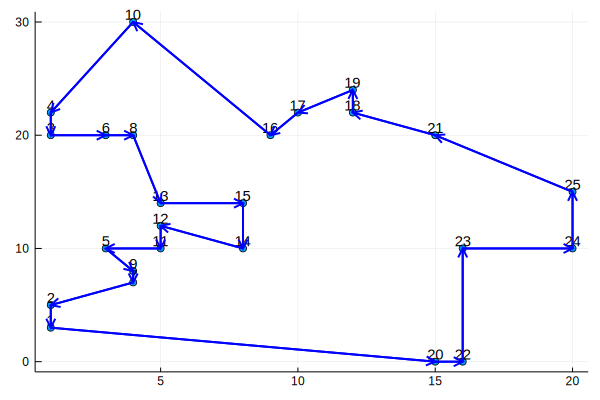

Gurobi Optimizer version 9.0.1 build v9.0.1rc0 (linux64)
Optimize a model with 651 rows, 649 columns and 2955 nonzeros
Model fingerprint: 0x10793a56
Variable types: 24 continuous, 625 integer (625 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [1e+00, 3e+01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 49 rows and 26 columns
Presolve time: 0.01s
Presolved: 602 rows, 623 columns, 2810 nonzeros
Variable types: 23 continuous, 600 integer (600 binary)
Found heuristic solution: objective 357.5103341

Root relaxation: objective 7.853596e+01, 85 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0   78.53596    0   30  357.51033   78.53596  78.0%     -    0s
     0     0   96.67922    0   47  357.51033   96.67922  73.0%     -    0s
H    0     0                     206.5651808   96.

In [7]:
@time valor,ciclo=resuelveMTZ("ejemplo.txt")
println("Valor= ",valor)
println("Ciclo= ",ciclo)

# D. DFZ para el problema del vendedor viajero.

## D1. Implementación mediante generación de filas y resolución iterativa de PLE.

En este laboratorio estudiaremos otro modelo para TSP mucho más efectivo, pero con una cantidad exponencial de restricciones.
El siguiente es el modelo DFZ (Dantzig-Fulkerson-Johnson)

\begin{align*}
(\text{DFZ})\qquad \min &\sum_{i=1}^N\sum_{j=1}^N z_{i,j}d(i,j)\\
z_{i,i}&=0,& \forall i\in [N]\\
\sum_{j=1}^N z_{i,j} &= 1,& \forall i\in [N]\\
\sum_{j=1}^N z_{j,i} &= 1,& \forall i\in [N]\\
z_{i,j}+z_{j,i}&\leq 1,& \forall i,j\in[N]\\
z(\delta^+(S)) &\geq 1,& \forall S\subseteq [N], S\neq N, 1\in S. (\text{corte}(S))\\
z &\in \{0,1\}^{[N]\times [N]}
\end{align*}


El modelo DFZ posee una cantidad exponencial de restricciones de tipo (corte). Esto hace intractable escribir todas las restricciones y luego usar un solver para resolverlo. En lugar de eso tomaremos la siguiente ruta.

1. Generar modelo con variables **integrales** sin restricción de corte y resolverlo.
   Notar que si $z$ es el vector solución entonces $z$ es unión de ciclos. 
2. Mientras $z$ tenga más de un ciclo, buscar un ciclo $C$ y llamar $S=V(C)$, notar que la restricción $z(\delta^+(S))\geq 1$ no está satisfecha y luego podemos **agregar al modelo la restricción corte($S$) y volver a resolver**
3. Cuando $z$ tenga un solo ciclo, ésta será la solución óptima.

## Ejercicio 1

Cree el modelo DFZ en Gurobi **sin incluir las restricciones de corte** completando la siguiente celda. 

Luego resuélvalo y dibuje la salida usando la función dibujar. 

In [8]:
#Cargar nuevamente los datos de ejemplo (esto es para fijar los nombres de las variable)
N,x_pos,y_pos=lee_archivo("ejemplo.txt")
#Modelo DFZ
DFZ = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) #sin salida esta vez

#cree variables, objetivo y restricciones
@variable(DFZ, z[1:N,1:N], Bin)
@objective(DFZ, Min, sum(z[i,j]*euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]]) for i=1:N,j=1:N))
@constraints(DFZ, begin
        self[i=1:N], z[i,i]==0
        salida[i=1:N], sum(z[i,1:N])==1
        entrada[i=1:N], sum(z[1:N,i])==1
        dosciclos[i=1:N,j=1:N], z[i,j]+z[j,i]<=1
end)
    

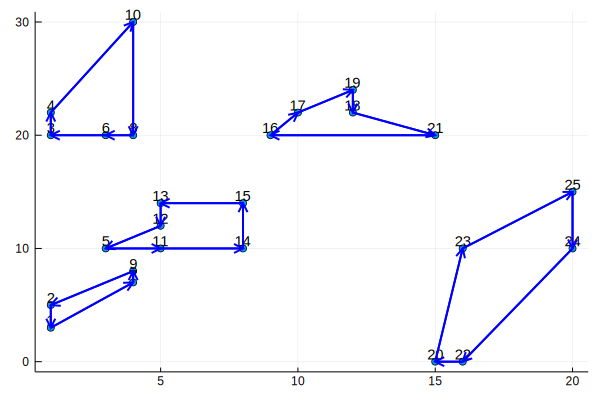

In [9]:
#complete los comandos para optimizar y dibujar
optimize!(DFZ)
dibuja(x_pos,y_pos,value.(z))

## Ejercicio 2 

La función *encuentra_ciclo* (del archivo preparacion.jl) detecta el único ciclo que pasa por la ciudad 1 en un grafo que es unión de ciclos. Ejecute la función encuentra_ciclo en la matriz value.(z) con los valores encontrados por DFZ. Luego agregue a DFZ la restricción asociada al corte encontrado. Optimize y dibuje su nueva solución.

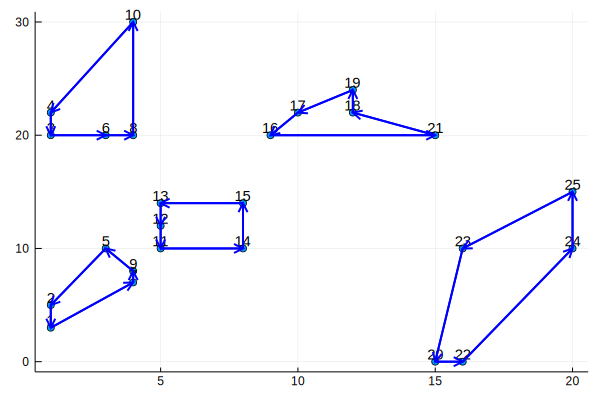

In [10]:
# Ejecutar función
ciclo=encuentra_ciclo(value.(z))

#agregar nueva fila (restricción) a DFZ 
#(indicación: setdiff(1:N, H) devuelve la diferencia entre el conjunto [N] y los elementos de un arreglo H)
@constraint(DFZ,sum(z[i,j] for i in ciclo , j in setdiff(1:N,ciclo))>=1)

#optimize nuevamente y dibuje
optimize!(DFZ)
dibuja(x_pos,y_pos,value.(z))

## Ejercicio 3

En este ejercicio debe automatizar la generación de filas. Para esto

### 3.1) 
Complete primero la siguiente plantilla

In [11]:
function resuelveDFZ(nombre_archivo)
    # recuperar N y puntos del archivo 
    N,x_pos,y_pos = lee_archivo(nombre_archivo)
    
    # Crear modelo DFZ inicial 
    DFZ = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) #sin salida esta vez
    @variable(DFZ, z[1:N,1:N], Bin)
    @objective(DFZ, Min, sum(z[i,j]*euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]]) for i=1:N,j=1:N))
    @constraints(DFZ, begin
        self[i=1:N], z[i,i]==0
        salida[i=1:N], sum(z[i,1:N])==1
        entrada[i=1:N], sum(z[1:N,i])==1
        dosciclos[i=1:N,j=1:N], z[i,j]+z[j,i]<=1
    end)
    
    
    itera=1
    while (true) 
        ## optimizar
        optimize!(DFZ)
        
        ## encontrar el ciclo que contiene a 1
        ciclo = encuentra_ciclo(value.(z))
        
        ## si el ciclo pasa por las N ciudades, calcular el valor del tour, escribir el ciclo y dibujarlo.
        if length(ciclo)==N
            valorTour=objective_value(DFZ)
            display(string("Número de iteraciones: ", itera))
            display(string("Tour óptimo encontrado, de largo ", valorTour))
            display(string("Lista de ciudades :", ciclo))
            dibuja(x_pos,y_pos,value.(z))
            return nothing
        else
            ## añadir a DFZ restricción de corte nuevo
            @constraint(DFZ,sum(z[i,j] for i in ciclo , j in setdiff(1:N,ciclo))>=1)
        end                
    itera=itera+1
    end  
end

resuelveDFZ (generic function with 1 method)

### 3.2) 
Ejecute su funcion en tres instancias (i30.txt, i40.txt, i50.txt), encontrando los tours óptimos

"Número de iteraciones: 15"

"Tour óptimo encontrado, de largo 510.6647294335125"

"Lista de ciudades :[1, 3, 23, 6, 18, 16, 26, 14, 5, 21, 13, 30, 8, 15, 4, 9, 11, 24, 29, 17, 19, 20, 25, 7, 28, 10, 27, 22, 12, 2]"

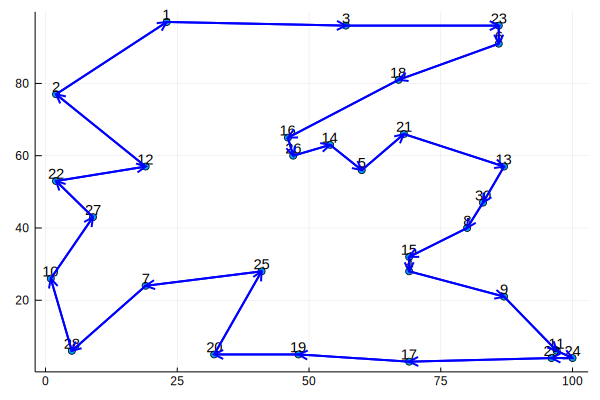

  1.735300 seconds (3.51 M allocations: 169.153 MiB, 3.18% gc time)


In [12]:
@time resuelveDFZ("i30.txt")

"Número de iteraciones: 17"

"Tour óptimo encontrado, de largo 526.5958260045661"

"Lista de ciudades :[1, 8, 3, 36, 28, 2, 14, 37, 32, 35, 27, 40, 4, 31, 5, 25, 18, 33, 17, 30, 16, 11, 10, 29, 34, 20, 12, 9, 7, 13, 39, 6, 15, 38, 26, 22, 21, 24, 23, 19]"

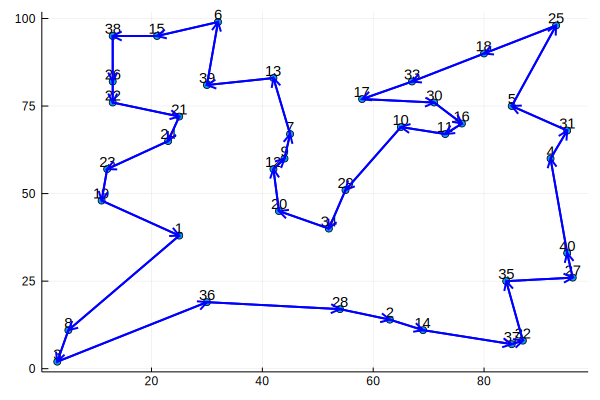

  1.622466 seconds (637.98 k allocations: 21.167 MiB, 1.69% gc time)


In [13]:
@time resuelveDFZ("i40.txt")

"Número de iteraciones: 21"

"Tour óptimo encontrado, de largo 560.9159465468153"

"Lista de ciudades :[1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

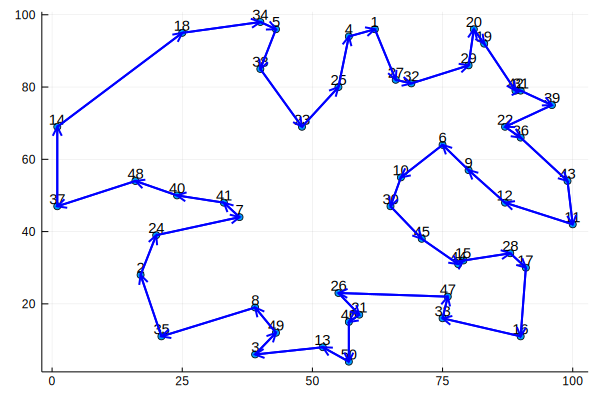

  3.537461 seconds (1.10 M allocations: 34.939 MiB)


In [14]:
@time resuelveDFZ("i50.txt")

## D2. Implementación mediante generación de filas usando lazy-constraints-callbacks.

La técnica anterior permite resolver TSP para instancias de tamaño moderado resolviendo una serie de PLE
con más y más restricciones. Notamos que en cada uno de estos PLE, el solver debe realizar branch and bound 
(o más precisamente branch and cut), sin necesariamente reutilizar el trabajo anterior.

Una manera de hacer este proceso de manera más eficiente es realizar una sola ejecución de branch and cut 
y agregar estas restricciones al modelo no al final del mismo si no cada vez que se encuentra un incumbente.
Los solvers modernos permiten pausar branch and bound en algunos puntos clave, luego llamar a una función externa
y finalmente despausar la ejecución (a esto se le llama un callback).

En esta sección implementaremos una función callback del tipo lazy-constraint.
Básicamente una lazy-constraint es una restricción que no se revisa desde el principio de la ejecución si no que solo
es agregada al modelo una vez que encontramos un incumbente que no la satisface.

Es posible darle al solver una lista de lazy-constraints desde el principio o generarla via callbacks.

El modo de implementar una función callback en jump+gurobi (en genérico) es como sigue:
```julia
    #se crea un modelo (para este ejemplo, supongamos que tiene una variable x
    model = Model(... 
    @variable(model, x, ...
    @objective(
    @constraints(

    #esta función se llamará cuando Gurobi piensa que tiene una solución entera incumbente
    function mi_callback(cb_data)
        #comando para recuperar valor de la variable x y guardarlo en una variable temporal
        x_val = callback_value(cb_data, x)

        #Nota: la implementación actual de Gurobi podría llamar a esta función cuando la solución es fraccional por lo
        #      que conviene revisar integralidad.
        
        tolerancia=0.001
        if !(abs(x-round(x))<tolerancia)
          display(string("callback en solución fraccional"))
          return nothing
        end
        
        #sabemos que x es integral
        # buscar restriccion a agregar
        ..
        restriccion_nueva = @build_constraint( .. restriccion ..)
        MOI.submit(model, MOI.LazyConstraint(cb_data), restriccion)
        end
    end

    #mandar función callback al solver.
    MOI.set(model, MOI.LazyConstraintCallback(), mi_callback)

    #si optimizamos, el solver usará la función callback para confirmar factibilidad de sus soluciones, agregando
    #restricciones si es necesario
```

## Ejercicio 4. 

### 4.1) 
Complete la siguiente función para resolver DFZ usando callbacks.


In [15]:
function resuelveDFZconCallbacks(nombrearchivo)
    # recuperar N y puntos del archivo 
    N,x_pos,y_pos=lee_archivo(nombrearchivo)
    
    # Crear modelo DFZCall inicial 
    DFZCall = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) 
    @variable(DFZCall, z[1:N,1:N], Bin)
    @objective(DFZCall, Min, sum(z[i,j]*euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]]) for i=1:N,j=1:N))
    @constraints(DFZCall, begin
        self[i=1:N], z[i,i]==0
        salida[i=1:N], sum(z[i,1:N])==1
        entrada[i=1:N], sum(z[1:N,i])==1
        dosciclos[i=1:N,j=1:N], z[i,j]+z[j,i]<=1
    end)                
    #implementar función callback
                
    function mi_callback(cb_data)
        display(string("Ejecutando callback"))
 
        ##Recupera variables z de cb_data
        z_val=zeros(N,N)
        for i=1:N, j=1:N
            z_val[i,j] = callback_value(cb_data, z[i,j])
        end    
        
        ##Revisar fraccionalidad
        tolerancia=0.001
        if (!all( x-> abs(x-round(x))<tolerancia, z_val))
          display(string("callback en solución fraccional"))
          return nothing
        end
        
        ## encontrar el ciclo que contiene a 1
        ciclo = encuentra_ciclo(z_val)
        
        if (length(ciclo)<N) ## si el ciclo no pasa por las N ciudades
            display(string("Agregando corte: ", ciclo))
            restriccion_nueva = @build_constraint(sum(z[i, j] for i in ciclo, j in setdiff(1:N, ciclo))>=1)
            MOI.submit(DFZCall, MOI.LazyConstraint(cb_data), restriccion_nueva)
        end
    end                        
    
     MOI.set(DFZCall, MOI.LazyConstraintCallback(), mi_callback)

    #Optimizar, reportar solución y dibujar.
    optimize!(DFZCall)
    valorTour = objective_value(DFZCall)
    ciclo = encuentra_ciclo(value.(DFZCall[:z]))
    display(string("Tour óptimo encontrado, de largo ", valorTour))
    display(string("Lista de ciudades :", ciclo))
    dibuja(x_pos, y_pos, value.(DFZCall[:z]))
    return valorTour, ciclo
end    

resuelveDFZconCallbacks (generic function with 1 method)

### 4.2) 
Ejecute su funcion en cuatro instancias (ejemplo.txt, i30.txt, i40.txt, i50.txt), encontrando los tours óptimos.

"Ejecutando callback"

"Agregando corte: [1, 2, 19, 7, 18, 9, 12, 11, 16, 5]"

"Ejecutando callback"

"Agregando corte: [1, 25, 2, 24, 3, 23]"

"Ejecutando callback"

"Agregando corte: [1, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 25, 2, 24]"

"Ejecutando callback"

"Agregando corte: [1, 7, 24, 5, 25, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 23, 22, 24, 25, 21, 19, 17, 18, 16, 15, 13, 14, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 23, 22, 24, 25, 21, 18, 16, 15, 13, 14, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 23, 22, 24, 25, 21, 19, 10, 17, 18, 16, 15, 13, 14, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 7, 5, 9, 2]"

"Ejecutando callback"

"Agregando corte: [1, 7, 12, 13, 15, 14, 11, 5, 9, 2]"

"Ejecutando callback"

"Agregando corte: [1, 7, 24, 25, 21, 16, 17, 19, 18, 12, 13, 15, 14, 11, 5, 9, 2]"

"Ejecutando callback"

"Agregando corte: [1, 7, 24, 25, 21, 16, 17, 19, 18, 3, 4, 10, 8, 6, 12, 13, 15, 14, 11, 5, 9, 2]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 2, 7, 9, 5, 11, 14, 12, 13, 15, 16, 17, 19, 18, 21, 25, 24, 23, 22, 20]"

"Ejecutando callback"

"Agregando corte: [1, 16, 17, 10, 4, 3, 6, 8, 13, 12, 15, 14, 11, 5, 9, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 22, 23, 24, 25, 21, 18, 19, 6, 8, 13, 15, 11, 12, 14, 9, 5, 7, 2, 20]"

"Ejecutando callback"

"Ejecutando callback"

"Agregando corte: [1, 20, 22, 23, 24, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 22, 23, 24, 9, 5, 11, 12, 14, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 22, 23, 24, 19, 18, 21, 25, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 22, 23, 24, 19, 18, 21, 25, 9, 5, 11, 12, 14, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 22, 23, 24, 17, 10, 4, 3, 6, 8, 13, 15, 16, 19, 18, 21, 25, 7, 2]"

"Ejecutando callback"

"Agregando corte: [1, 20, 22, 23, 24, 25, 21, 18, 19, 6, 8, 16, 17, 10, 4, 3, 11, 5, 9, 7, 2]"

"Ejecutando callback"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Tour óptimo encontrado, de largo 106.31321194439427"

"Lista de ciudades :[1, 20, 22, 23, 24, 25, 21, 18, 19, 17, 16, 10, 4, 3, 6, 8, 13, 15, 14, 12, 11, 5, 9, 7, 2]"

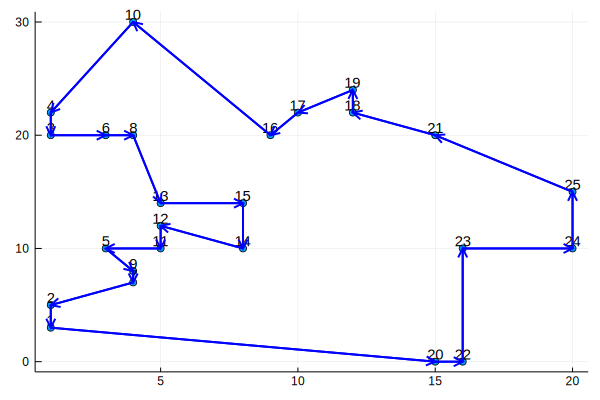

  1.171559 seconds (3.25 M allocations: 160.797 MiB, 3.99% gc time)


(106.31321194439427, [1, 20, 22, 23, 24, 25, 21, 18, 19, 17  …  8, 13, 15, 14, 12, 11, 5, 9, 7, 2])

In [16]:
@time resuelveDFZconCallbacks("ejemplo.txt")

"Ejecutando callback"

"Agregando corte: [1, 20, 24, 13, 19, 9, 6, 28, 14, 10, 11, 17, 21, 23, 7, 16, 30, 29, 18, 3, 22, 27, 25, 4, 5, 15]"

"Ejecutando callback"

"Agregando corte: [1, 30, 2, 29, 3, 28]"

"Ejecutando callback"

"Agregando corte: [1, 30, 2, 28, 3, 27]"

"Ejecutando callback"

"Agregando corte: [1, 29, 2, 30]"

"Ejecutando callback"

"Agregando corte: [1, 3, 21, 13]"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 16, 26, 27, 10, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 14, 5, 21, 13, 26, 16, 27, 10, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 14, 5, 21, 13, 25, 7, 28, 20, 19, 17, 9, 4, 15, 8, 30, 26, 16, 27, 10, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 16, 26, 14, 5, 21, 13, 25, 7, 28, 27, 10, 22, 12, 2]"

"Ejecutando callback"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 21, 13, 11, 24, 29, 20, 19, 17, 9, 4, 15, 8, 30, 25, 7, 28, 10, 27, 22, 12, 2]"

"Ejecutando callback"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 3, 13, 30, 8, 15, 4, 17, 20, 25, 7, 28, 10, 19, 27, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 3, 5, 26, 16, 14, 21, 13, 30, 8, 15, 4, 17, 19, 20, 25, 7, 28, 27, 10, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 3, 5, 26, 16, 14, 21, 9, 29, 24, 11, 13, 30, 8, 15, 4, 17, 19, 20, 25, 7, 28, 27, 10, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 16, 26, 14, 5, 21, 13, 30, 8, 15, 4, 17, 19, 20, 25, 7, 28, 10, 27, 22, 12, 2]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 3, 23, 6, 18, 21, 5, 13, 30, 8, 15, 4, 9, 11, 24, 29, 17, 19, 20, 25, 7, 28, 10, 27, 22, 12, 2]"

"Ejecutando callback"

"Agregando corte: [1, 2, 12, 22, 27, 10, 28, 7, 25, 20, 19, 17, 29, 24, 11, 9, 4, 15, 8, 30, 13, 21, 5, 14, 26, 16]"

"Ejecutando callback"

"Agregando corte: [1, 3, 18, 23, 6, 13, 30, 8, 15, 4, 9, 11, 24, 29, 17, 19, 20, 25, 7, 28, 10, 27, 22, 12, 2]"

"Ejecutando callback"

"Tour óptimo encontrado, de largo 510.66472943351243"

"Lista de ciudades :[1, 2, 12, 22, 27, 10, 28, 7, 25, 20, 19, 17, 29, 24, 11, 9, 4, 15, 8, 30, 13, 21, 5, 14, 26, 16, 18, 6, 23, 3]"

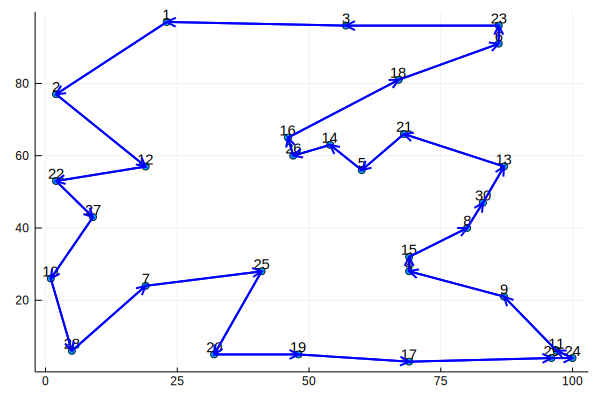

  0.117010 seconds (312.18 k allocations: 12.607 MiB)


(510.66472943351243, [1, 2, 12, 22, 27, 10, 28, 7, 25, 20  …  13, 21, 5, 14, 26, 16, 18, 6, 23, 3])

In [17]:
@time resuelveDFZconCallbacks("i30.txt")

"Ejecutando callback"

"Agregando corte: [1, 19, 14, 13, 8, 2, 12, 30, 20, 7, 33, 29, 17, 18, 10, 25, 4, 28, 6, 16, 22, 37, 38, 32, 3, 5, 24, 34]"

"Ejecutando callback"

"Agregando corte: [1, 40, 2, 39]"

"Ejecutando callback"

"Agregando corte: [1, 20, 34, 29, 9, 12, 7, 13, 6, 15, 38, 26, 39, 21, 22, 24, 23, 19]"

"Ejecutando callback"

"Agregando corte: [1, 39, 13, 14, 28, 5, 25, 2, 36, 3, 31, 4, 30, 16, 12, 15, 38, 26, 22, 8, 21, 9, 19, 10, 18, 11, 17, 33]"

"Ejecutando callback"

"Agregando corte: [1, 39, 13, 6, 15, 37, 19, 35, 21, 32, 25, 27, 26, 22, 31, 4, 5, 40]"

"Ejecutando callback"

"Agregando corte: [1, 36, 3, 40, 4, 5, 29, 24, 21, 39, 27, 12, 17, 19]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 26, 22, 21, 24, 39, 13, 17, 33, 10, 11, 16, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 36, 3, 8]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 26, 22, 21, 24, 39, 13, 7, 9, 12, 20, 29, 34, 28, 36, 3, 8]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 22, 21, 24, 26, 38, 15, 6, 39, 13, 17, 33, 10, 11, 16, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 36, 3, 8]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 22, 21, 24, 26, 38, 15, 6, 39, 13, 7, 9, 12, 20, 29, 34, 28, 36, 3, 8]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 26, 22, 21, 24, 39, 13, 17, 33, 10, 11, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 36, 3, 8]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 7, 9, 12, 29, 34, 20]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 10, 11, 16, 30, 33, 18, 25, 5, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 36, 3, 8]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 33, 30, 16, 11, 10, 29, 34, 20]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 10, 11, 16, 30, 33, 18, 25, 5, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 34, 29, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 36, 3, 8, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 7, 9, 12, 29, 34, 20]"

"Ejecutando callback"

"Agregando corte: [1, 36, 3, 8, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 33, 30, 16, 11, 10, 29, 34, 20]"

"Ejecutando callback"

"Agregando corte: [1, 7, 9, 12, 29, 34, 20]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 17, 33, 30, 16, 11, 10, 7, 9, 12, 29, 34, 20]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 12, 7, 9, 10, 11, 6, 39, 13, 17, 33, 30, 16, 4, 31, 25, 18, 5]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 12, 7, 9, 10, 11, 6, 39, 13, 17, 33, 30, 16, 4, 31, 25, 18, 5]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 22, 26, 38, 15, 21, 12, 7, 9, 10, 11, 6, 39, 13, 17, 33, 30, 16, 4, 31, 25, 18, 5]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 12, 7, 9, 29, 34, 20, 10, 11, 6, 39, 13, 17, 33, 30, 16, 4, 31, 25, 18, 5]"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 12, 7, 9, 29, 34, 20, 10, 11, 6, 39, 13, 17, 33, 30, 16, 4, 31, 25, 18, 5]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 7, 9, 17, 10, 11, 16, 30, 33, 18, 25, 5, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 34, 29, 12, 20]"

"Ejecutando callback"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 36, 3, 8, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 7, 9, 12, 29, 34, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 19, 23, 24, 12, 9, 7, 17, 10, 11, 16, 30, 33, 18, 25, 5, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 36, 3, 8]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 8, 3, 36, 28, 2, 14, 37, 32, 35, 27, 40, 4, 31, 5, 25, 18, 33, 30, 16, 11, 10, 17, 7, 13, 39, 6, 15, 38, 26, 22, 21, 24, 23, 19]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 8, 3, 36, 28, 2, 14, 37, 32, 35, 27, 40, 4, 31, 5, 25, 18, 33, 17, 10, 29, 34, 20, 12, 9, 7, 13, 39, 6, 15, 38, 26, 22, 21, 24, 23, 19]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Ejecutando callback"

"Agregando corte: [1, 8, 3, 36, 28, 2, 14, 37, 32, 35, 27, 40, 4, 31, 5, 25, 18, 33, 30, 16, 11, 10, 17, 7, 9, 12, 24, 21, 39, 13, 6, 15, 38, 26, 22, 23, 19]"

"Tour óptimo encontrado, de largo 526.5958260045661"

"Lista de ciudades :[1, 19, 23, 24, 21, 22, 26, 38, 15, 6, 39, 13, 7, 9, 12, 20, 34, 29, 10, 11, 16, 30, 17, 33, 18, 25, 5, 31, 4, 40, 27, 35, 32, 37, 14, 2, 28, 36, 3, 8]"

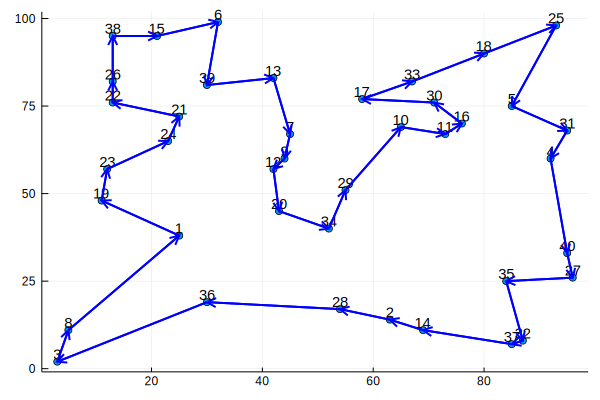

  0.510742 seconds (825.38 k allocations: 26.462 MiB)


(526.5958260045661, [1, 19, 23, 24, 21, 22, 26, 38, 15, 6  …  27, 35, 32, 37, 14, 2, 28, 36, 3, 8])

In [18]:
@time resuelveDFZconCallbacks("i40.txt")

"Ejecutando callback"

"Agregando corte: [1, 44, 22, 43, 23]"

"Ejecutando callback"

"Agregando corte: [1, 50, 2, 49, 3, 48]"

"Ejecutando callback"

"Agregando corte: [1, 50, 2, 49]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 23, 25, 27, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 41, 7, 24, 40, 18, 38, 23, 25, 27, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 37, 14, 48, 18, 38, 23, 25, 27, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 41, 7, 24, 40, 37, 14, 48, 18, 38, 23, 25, 27, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 20, 29, 19, 18, 38, 23, 25, 27, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 37, 14, 48, 18, 38, 23, 25, 27, 32]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 27]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 49, 8, 35, 2, 24, 7, 41, 40, 48, 14, 37, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 49, 8, 35, 2, 24, 7, 41, 40, 48, 14, 37, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 49, 8, 35, 2, 24, 7, 41, 40, 48, 14, 37, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 49, 8, 35, 2, 24, 7, 41, 40, 48, 14, 37, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 49, 8, 35, 2, 24, 7, 41, 40, 48, 14, 37, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 23, 10, 30, 45, 44, 15, 28, 17, 11, 43, 12, 9, 6, 32, 27]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 11, 43, 42, 31, 39, 22, 36, 15, 28, 17, 16, 33, 47, 44, 45, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 25, 4, 5, 34, 18, 38, 23, 10, 30, 45, 44, 15, 28, 17, 11, 43, 12, 9, 6, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 20, 19, 29, 22, 36, 9, 6, 32, 27, 25, 23, 38, 18, 34, 5]"

"Ejecutando callback"

"Agregando corte: [1, 4, 20, 19, 29, 22, 36, 12, 43, 11, 9, 6, 32, 27, 25, 23, 38, 18, 34, 5]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 25, 23]"

"Ejecutando callback"

"Agregando corte: [1, 4, 20, 19, 29, 22, 36, 10, 30, 45, 12, 43, 11, 9, 6, 32, 27, 25, 23, 38, 18, 34, 5]"

"Ejecutando callback"

"Agregando corte: [1, 4, 38, 18, 34, 5]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 32, 27, 4]"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 23, 7, 41, 40, 24, 2, 35, 8, 49, 3, 13, 50, 33, 47, 16, 17, 28, 15, 44, 45, 30, 10, 9, 6, 32, 27]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 47, 15, 44, 45, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 50, 13, 46, 21, 26, 33, 47, 15, 44, 45, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 36, 22, 6, 9, 12, 43, 11, 17, 28, 15, 44, 45, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 23, 38, 5, 34, 18, 14, 37, 48, 40, 41, 7, 24, 2, 35, 8, 49, 3, 13, 50, 33, 47, 16, 17, 28, 15, 44, 45, 30, 10, 9, 6, 32, 27]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 23, 10, 30, 45, 15, 44, 47, 33, 16, 17, 28, 11, 43, 12, 9, 6, 22, 36, 39, 31, 42, 19, 20, 29, 32, 27]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 32, 27, 25, 23, 7, 41, 40, 48, 37, 14, 18, 38, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 36, 22, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 32, 27, 25, 23, 7, 41, 40, 48, 37, 14, 18, 38, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 36, 22, 32, 27, 25, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 36, 22, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 25, 23, 10, 30, 45, 44, 15, 28, 17, 11, 43, 12, 9, 6, 22, 36, 39, 31, 42, 19, 20, 29, 32, 27]"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 25, 23, 10, 30, 45, 44, 15, 28, 17, 11, 43, 12, 9, 6, 32, 27, 29, 19, 20]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 17, 28, 15, 44, 45, 30, 10, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 9, 12, 43, 11, 17, 28, 15, 44, 45, 30, 10, 6, 32, 27, 25, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 15, 44, 47, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 23, 10, 30, 45, 26, 21, 46, 13, 50, 33, 16, 47, 44, 15, 28, 17, 11, 43, 12, 9, 6, 32, 27, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 32, 27, 25, 23, 10, 30, 45, 26, 21, 46, 13, 50, 33, 16, 47, 44, 15, 28, 17, 11, 43, 12, 9, 6, 22, 36, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 6, 32, 27, 25, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 43, 11, 12, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 9, 6, 32, 27, 25, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 39, 31, 42, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 36, 22, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 23, 10, 30, 45, 26, 21, 46, 13, 50, 33, 16, 47, 44, 15, 28, 17, 11, 43, 12, 9, 6, 22, 36, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 50, 13, 46, 21, 26, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 15, 44, 47, 33, 50, 13, 46, 21, 26, 8, 49, 3, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 47, 44, 15, 28, 17, 16, 33, 50, 13, 46, 21, 26, 8, 49, 3, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 10, 30, 9, 12, 43, 11, 28, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 26, 21, 46, 50, 13, 3, 49, 8, 35, 24, 2, 37, 14, 48, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 27, 32]"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 27, 32]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 50, 13, 3, 49, 8, 26, 46, 21, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 23, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 43, 11, 28, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 28, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 32, 27, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 25, 27, 32]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 23, 25, 27, 32, 6, 10, 30, 45, 26, 21, 46, 13, 50, 33, 16, 47, 44, 15, 28, 17, 11, 43, 12, 9, 36, 22, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 38, 18, 14, 37, 48, 40, 41, 7, 8, 49, 3, 13, 50, 46, 21, 26, 45, 30, 10, 23, 25, 27, 32, 6, 9, 12, 11, 43, 36, 22, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 43, 11, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 30, 10, 9, 12, 43, 11, 28, 17, 16, 33, 50, 13, 46, 21, 26, 8, 49, 3, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 27, 32, 6, 9, 12, 11, 43, 36, 22, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 25, 27, 32, 6, 9, 12, 11, 43, 36, 22, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 25, 27, 32, 6, 9, 12, 11, 43, 36, 22, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 7, 41, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 7, 41, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 47, 44, 15, 28, 17, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 37, 14, 48, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 15, 44, 47, 16, 33, 50, 13, 3, 49, 8, 7, 41, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 7, 41, 30, 10, 23, 25, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Ejecutando callback"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 50, 13, 46, 21, 26, 8, 49, 3, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 37, 14, 48, 40, 41, 7, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 27, 32, 6, 9, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 37, 14, 48, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Ejecutando callback"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 38, 18, 14, 37, 2, 24, 48, 40, 41, 7, 23, 25, 27, 32]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 37, 14, 48, 40, 41, 7, 23, 10, 30, 45, 44, 15, 28, 17, 11, 43, 12, 9, 6, 22, 36, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 4, 5, 34, 18, 38, 23, 10, 30, 45, 21, 33, 16, 47, 44, 15, 28, 17, 11, 43, 12, 9, 6, 22, 36, 39, 31, 42, 29, 19, 20]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 7, 41, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 29, 19, 20, 27, 32, 6, 9, 12, 43, 11, 28, 17, 16, 47, 44, 15, 45, 30, 10, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"callback en solución fraccional"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 15, 44, 47, 16, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 20, 19, 29, 42, 31, 39, 22, 36, 9, 12, 43, 11, 28, 17, 16, 33, 47, 44, 15, 45, 30, 10, 6, 32, 27, 25, 23, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 47, 33, 50, 13, 3, 49, 8, 35, 2, 24, 40, 7, 41, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 26, 21, 46, 50, 13, 3, 49, 8, 35, 24, 2, 37, 14, 48, 40, 41, 7, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 47, 44, 15, 28, 17, 16, 33, 50, 13, 46, 21, 26, 8, 49, 3, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 40, 7, 41, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 27, 32, 6, 9, 10, 30, 45, 15, 44, 47, 33, 50, 13, 46, 21, 26, 8, 49, 3, 35, 2, 24, 40, 41, 7, 23, 25, 38, 18, 34, 5, 4]"

"Ejecutando callback"

"Agregando corte: [1, 4, 25, 27, 32]"

"Tour óptimo encontrado, de largo 560.9159465468153"

"Lista de ciudades :[1, 27, 32, 29, 20, 19, 42, 31, 39, 22, 36, 43, 11, 12, 9, 6, 10, 30, 45, 44, 15, 28, 17, 16, 33, 47, 26, 21, 46, 50, 13, 3, 49, 8, 35, 2, 24, 7, 41, 40, 48, 37, 14, 18, 34, 5, 38, 23, 25, 4]"

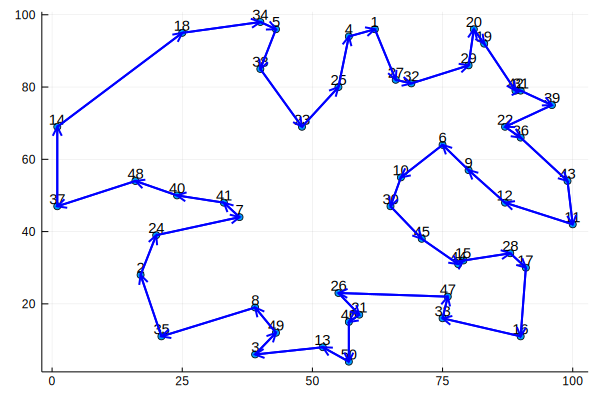

  2.140508 seconds (5.59 M allocations: 133.329 MiB, 2.36% gc time)


(560.9159465468153, [1, 27, 32, 29, 20, 19, 42, 31, 39, 22  …  48, 37, 14, 18, 34, 5, 38, 23, 25, 4])

In [19]:
@time resuelveDFZconCallbacks("i50.txt")

# E. Resolución de la relajación fraccional de DFZ

En instancias más grandes se hace complejo usar el esquema anterior pues estamos resolviendo demasiados PLE.
Una forma de mejorar esto es incluir (algunas) restricciones de corte no en el PLE, sino en su relajación fraccional.

\begin{align*}
(\text{DFZ-frac})\qquad \min &\sum_{i=1}^N\sum_{j=1}^N z_{i,j}d(i,j)\\
z_{i,i}&=0,& \forall i\in [N]\\
\sum_{j=1}^N z_{i,j} &= 1,& \forall i\in [N]\\
\sum_{j=1}^N z_{j,i} &= 1,& \forall i\in [N]\\
z_{i,j}+z_{j,i}&\leq 1,& \forall i,j\in[N]\\
z(\delta^+(S)) &\geq 1,& \forall S\subseteq [N], S\neq N, 1\in S. (\text{corte}(S))\\
z_{i,j}&\geq0,& \forall (i,j) \in [N]\times [N]
\end{align*}

El objetivo de esta sección es programar un método que resuelva la relajación fraccional de DFZ (no la integral).

Para esto, seguiremos un esquema similar al de la sección D.1. 

1. Generar modelo con variables **fraccionales** sin restricción de corte y resolverlo. 
2. Encontrar conjunto $S$ que contenga a 1 y que tenga corte $z(\delta^+(S))$ mínimo. Si este corte es de valor al menos 1 entonces $z$ será la solución óptima.
3. De otra forma, agregar la restricción asociada al corte de $S$ al modelo.

Para implementar el paso 2, lo ideal es usar un algoritmo combinatorial rápido para mincut como Stoer-Watson o Queyranne; o uno aleatorizado como Karger. En vez de eso, en este laboratorio calcularemos mincut mediante (una secuencia de) programas lineales puros. Básicamente calcularemos el $1$-$t$ corte mínimo para todo $t\neq 1$, y si alguno tiene valor menor que 1, agregaremos la restricción al modelo.

Usaremos el siguiente PL puro (vimos uno similar en auxiliar). 


\begin{align*}
min \sum_{i=1}^N\sum_{j=1}^N &q_{i,j}z_{i,j}\\
p_1&\geq 1\\
p_t&=0\\
p_i-p_j+q(j,i)&\geq 0\\
q&\ge 0
\end{align*}


Aquí las variables son los vectores q (largo) y p (potencial); el vector $z$ es dato. Básicamente el PL busca asignar potenciales entre 0 y 1 a cada vértice y llama $q(i,j)$ a la diferencia de potencial entre $i$ y $j$. En un mundo ideal, una solución óptima asignaría potenciales 0 a aquellos puntos en el lado de $t$ y potencial 1 a aquellos puntos en el lado de $1$ del corte y luego $q_e=1$ solo para los arcos que cruzan el corte. Esta idea también funciona de manera fraccional y de hecho se puede probar que 
$$S=\{i \in [N], p_i\geq \alpha\}$$
es un $1$-$ t$ corte minimo para cualquier $\alpha$ entre 0 y 1.

## Ejercicio 5. 

Implemente una funcion que reciba N, un indice t en 2:N, y un vector de pesos w (que toma el rol del z en el PL anterior) 
y devuelve el valor del minimo 1-t corte (usando pesos w) y un arreglo con los nodos al lado 1 de ese corte. 
Para esto complete la siguiente plantilla

In [20]:
function cut(N, t, w)
    #calcula el mincut de 1 a t usando los valores de w
    mincut = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) #sin salida esta vez
    @variable(mincut, q[i=1:N, j=1:N]>=0)
    @variable(mincut, p[i=1:N])
    @objective(mincut, Min, sum(q[i,j]*w[i,j] for i in 1:N, j in 1:N))
    @constraints(mincut, begin
            p[1]>=1
            p[t]==0
            Potencial[i=1:N,j=1:N], p[i]-p[j]+q[j,i]>=0
        end)
    #display(mincut)
    optimize!(mincut)
    valor=objective_value(mincut)
    corte=findall(x->x>=1/2, value.(p))
    return valor, corte
end

cut (generic function with 1 method)

Pruebe su funcion en el grafo con 6 vertices y pesos dados por el vector w siguiente (para t=2, 3, 6 debería obtener cortes de valor 1, 2 y 3 respectivamente)

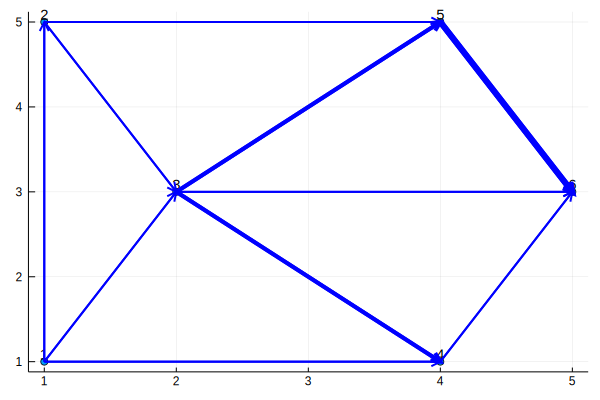

(1.0, [1, 3, 4, 5, 6])
(2.0, [1, 2, 4, 5, 6])
(3.0, [1])


In [21]:
xxpos=[1, 1, 2, 4, 4, 5]
yypos=[1, 5, 3, 1, 5, 3]
w=zeros(6,6)
for (i,j,k) in [(1, 2, 1), (1, 3, 1), (2, 3, 1), (3, 4, 2), (3, 5, 2), (4, 6, 1), (5, 6, 3), (3,6,1), (2,5,1), (1,4,1)]
    w[i,j]=k
end
dibuja(xxpos,yypos,w)
println(cut(6,2,w))
println(cut(6,3,w))
println(cut(6,6,w))


## Ejercicio 6

### 6.1) 
Implemente la siguiente función para calcular la solucion optima fraccional de DFZ similar a como lo hizo en el Ejercicio 3 (esta vez la solución no es necesariamente un ciclo)


In [22]:
function resuelveDFZfraccional(nombrearchivo)
# abre nombrearchivo, resuelve iterativamente DFZ, dibuja la solucion final y devuelve en pantalla el valor del tour fraccional
    
    # recuperar N y puntos del archivo 
    N,x_pos,y_pos=lee_archivo(nombrearchivo)
    
    # Crear modelo DFZfrac inicial 
    DFZfrac = Model(optimizer_with_attributes(() -> Gurobi.Optimizer(GUROBI_ENV),"OutputFlag" => 0)) #sin salida esta vez

    @variable(DFZfrac, z[i=1:N, j=1:N]>=0)
    @objective(DFZfrac, Min, sum(z[i,j]*euclidean([x_pos[i],y_pos[i]],[x_pos[j],y_pos[j]]) for i=1:N,j=1:N))
    @constraints(DFZfrac, begin
        self[i=1:N], z[i,i]==0
        salida[i=1:N], sum(z[i,1:N])==1
        entrada[i=1:N], sum(z[1:N,i])==1
        dosciclos[i=1:N, j=1:N], z[i,j]+z[j,i]<=1
    end)
    
    iteracion=0
    listo=false
    while (!listo)
        listo=true #si no encontramos cortes nuevo en la ejecución, terminamos al final del loop.
        iteracion=iteracion+1
        
        ## optimizar y reportar valor.
        optimize!(DFZfrac)
        display(string("Iteración: ",iteracion, ", valor fraccional: ", objective_value(DFZfrac)))
        
       ## Encontrar algun 1-t corte de valor <1-epsilon, para epsilon=0.0001
        epsilon=0.0001
        for t in 2:N
            valor, corte = cut(N,t,value.(z)) 
            if (valor < 1-epsilon)
                @constraint(DFZfrac, sum(z[i,j] for i in corte, j in setdiff(1:N, corte))>=1)
                display(string("Agregando corte: ", corte))
                listo=false
                break
            end
        end
    end
    
    valorTour=objective_value(DFZfrac)
    display(string("Tour fraccional encontrado de largo ", valorTour))
    dibuja(x_pos,y_pos,value.(DFZfrac[:z]))
    return valorTour
end



resuelveDFZfraccional (generic function with 1 method)

### 6.2)
Ejecute su funcion en cuatro instancias (ejemplo.txt, i30.txt, i40.txt, i50.txt)), encontrando los tours fraccionales óptimos.

(Para referencia: el tour fraccional óptimo de "ejemplo.txt" tiene un valor cercano a 105.415)

"Iteración: 1, valor fraccional: 101.6830979596718"

"Agregando corte: [1, 2, 5, 7, 9, 11, 12, 13, 14, 15]"

"Iteración: 2, valor fraccional: 104.13287205689531"

"Agregando corte: [1, 2, 5, 7, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]"

"Iteración: 3, valor fraccional: 105.41588285679022"

"Tour fraccional encontrado de largo 105.41588285679022"

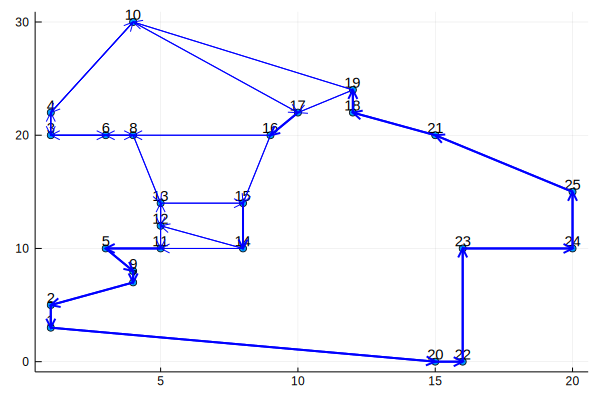

105.41588285679022

In [23]:
resuelveDFZfraccional("ejemplo.txt")

"Iteración: 1, valor fraccional: 480.15649976890205"

"Agregando corte: [1, 3, 6, 18, 23]"

"Iteración: 2, valor fraccional: 483.3685719769212"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30]"

"Iteración: 3, valor fraccional: 486.9642947222065"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30]"

"Iteración: 4, valor fraccional: 490.33079008371334"

"Agregando corte: [1, 2, 4, 5, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 25, 26, 27, 28, 30]"

"Iteración: 5, valor fraccional: 490.81836751033853"

"Agregando corte: [1, 2, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30]"

"Iteración: 6, valor fraccional: 490.9949900387153"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 12, 13, 15, 17, 18, 19, 20, 22, 23, 25, 27, 28, 30]"

"Iteración: 7, valor fraccional: 491.0621562236512"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30]"

"Iteración: 8, valor fraccional: 493.31037298419545"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30]"

"Iteración: 9, valor fraccional: 502.22231514515437"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 25, 27, 28, 30]"

"Iteración: 10, valor fraccional: 504.3186511715235"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30]"

"Iteración: 11, valor fraccional: 506.25301046166317"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 10, 12, 13, 15, 17, 18, 19, 20, 22, 23, 25, 27, 28, 30]"

"Iteración: 12, valor fraccional: 508.34934648803227"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30]"

"Iteración: 13, valor fraccional: 508.56839340714333"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 30]"

"Iteración: 14, valor fraccional: 510.66472943351243"

"Tour fraccional encontrado de largo 510.66472943351243"

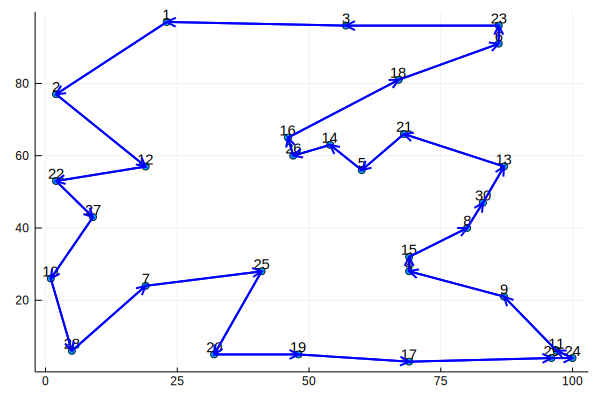

510.66472943351243

In [26]:
resuelveDFZfraccional("i30.txt")

"Iteración: 1, valor fraccional: 502.18613293816384"

"Agregando corte: [1, 3, 6, 8, 13, 15, 19, 21, 22, 23, 24, 26, 36, 38, 39]"

"Iteración: 2, valor fraccional: 506.2994596079297"

"Agregando corte: [1, 6, 7, 9, 12, 13, 15, 19, 20, 21, 22, 23, 24, 26, 29, 34, 38, 39]"

"Iteración: 3, valor fraccional: 508.2887395432419"

"Agregando corte: [1, 3, 4, 5, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 28, 30, 31, 33, 36, 38, 39]"

"Iteración: 4, valor fraccional: 508.62343736448054"

"Agregando corte: [1, 3, 4, 5, 6, 8, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 33, 34, 36, 38, 39]"

"Iteración: 5, valor fraccional: 509.3980165569926"

"Agregando corte: [1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 29, 30, 31, 33, 34, 36, 38, 39]"

"Iteración: 6, valor fraccional: 513.1360858245146"

"Agregando corte: [1, 2, 3, 4, 5, 6, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40]"

"Iteración: 7, valor fraccional: 513.805481466992"

"Agregando corte: [1, 2, 4, 5, 6, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]"

"Iteración: 8, valor fraccional: 516.1338253633563"

"Agregando corte: [1, 2, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40]"

"Iteración: 9, valor fraccional: 522.9107388744115"

"Agregando corte: [1, 3, 6, 7, 8, 9, 12, 13, 15, 19, 20, 21, 22, 23, 24, 26, 28, 29, 34, 36, 38, 39]"

"Iteración: 10, valor fraccional: 524.0031286477985"

"Agregando corte: [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 14, 16, 17, 18, 20, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40]"

"Iteración: 11, valor fraccional: 524.034529909872"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 38, 39, 40]"

"Iteración: 12, valor fraccional: 524.0454586464077"

"Tour fraccional encontrado de largo 524.0454586464077"

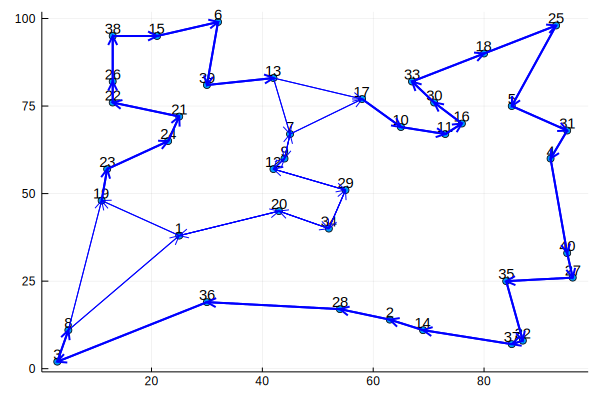

524.0454586464077

In [24]:
resuelveDFZfraccional("i40.txt")

"Iteración: 1, valor fraccional: 537.0461940348343"

"Agregando corte: [1, 4, 5, 18, 23, 25, 27, 32, 34, 38]"

"Iteración: 2, valor fraccional: 541.5264190300612"

"Agregando corte: [1, 4, 5, 18, 19, 20, 23, 25, 27, 29, 32, 34, 38]"

"Iteración: 3, valor fraccional: 546.9733482405821"

"Agregando corte: [1, 4, 6, 9, 10, 11, 12, 15, 17, 23, 25, 27, 28, 30, 32, 43, 44, 45]"

"Iteración: 4, valor fraccional: 547.717862181502"

"Agregando corte: [1, 4, 6, 9, 10, 11, 12, 15, 16, 17, 23, 25, 27, 28, 30, 32, 33, 43, 44, 45, 47]"

"Iteración: 5, valor fraccional: 549.6268720868192"

"Agregando corte: [1, 4, 5, 6, 9, 10, 11, 12, 15, 17, 18, 19, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32, 34, 36, 38, 39, 42, 43, 44, 45]"

"Iteración: 6, valor fraccional: 550.3713860277392"

"Agregando corte: [1, 4, 5, 6, 9, 10, 11, 12, 15, 16, 17, 18, 19, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32, 33, 34, 36, 38, 39, 42, 43, 44, 45, 47]"

"Iteración: 7, valor fraccional: 555.4262085376486"

"Agregando corte: [1, 4, 5, 7, 14, 18, 23, 24, 25, 27, 32, 34, 37, 38, 40, 41, 48]"

"Iteración: 8, valor fraccional: 556.0414886123677"

"Agregando corte: [1, 4, 5, 7, 14, 18, 19, 20, 23, 24, 25, 27, 29, 32, 34, 37, 38, 40, 41, 48]"

"Iteración: 9, valor fraccional: 557.1209392976581"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 15, 16, 17, 23, 24, 25, 27, 28, 30, 32, 33, 35, 40, 41, 44, 45, 47, 49, 50]"

"Iteración: 10, valor fraccional: 557.2721109213445"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 13, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 35, 40, 41, 44, 45, 46, 47, 49, 50]"

"Iteración: 11, valor fraccional: 557.4239126964438"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 23, 24, 25, 27, 28, 30, 32, 33, 34, 35, 37, 38, 40, 41, 44, 45, 47, 48, 49, 50]"

"Iteración: 12, valor fraccional: 557.5750843201303"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17, 18, 21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 34, 35, 37, 38, 40, 41, 44, 45, 46, 47, 48, 49, 50]"

"Iteración: 13, valor fraccional: 559.077532260114"

"Agregando corte: [1, 4, 6, 9, 10, 11, 12, 15, 16, 17, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 36, 39, 42, 43, 44, 45, 46, 47, 50]"

"Iteración: 14, valor fraccional: 559.1399532197034"

"Agregando corte: [1, 4, 19, 20, 22, 27, 29, 31, 32, 36, 39, 42]"

"Iteración: 15, valor fraccional: 559.2778647755789"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 21, 23, 24, 25, 26, 27, 28, 30, 32, 33, 35, 40, 41, 43, 44, 45, 46, 47, 49, 50]"

"Iteración: 16, valor fraccional: 559.5808381743648"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 23, 24, 25, 26, 27, 28, 30, 32, 34, 35, 37, 38, 40, 41, 43, 44, 45, 46, 48, 49, 50]"

"Iteración: 17, valor fraccional: 559.6032421144639"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]"

"Iteración: 18, valor fraccional: 559.7042332473927"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50]"

"Iteración: 19, valor fraccional: 559.7635264937246"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 23, 24, 25, 27, 28, 30, 32, 33, 34, 35, 37, 38, 40, 41, 43, 44, 45, 47, 48, 49, 50]"

"Iteración: 20, valor fraccional: 559.8543325724006"

"Agregando corte: [1, 4, 6, 9, 10, 11, 12, 15, 17, 19, 20, 22, 23, 25, 27, 28, 29, 30, 31, 32, 36, 39, 42, 43, 44, 45]"

"Iteración: 21, valor fraccional: 559.892326852153"

"Agregando corte: [1, 3, 4, 6, 9, 10, 11, 12, 13, 15, 16, 17, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 39, 42, 43, 44, 45, 46, 47, 50]"

"Iteración: 22, valor fraccional: 559.9248831655864"

"Agregando corte: [1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 35, 36, 37, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]"

"Iteración: 23, valor fraccional: 559.9268065427566"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]"

"Iteración: 24, valor fraccional: 560.7647749231288"

"Agregando corte: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50]"

"Iteración: 25, valor fraccional: 560.9159465468153"

"Tour fraccional encontrado de largo 560.9159465468153"

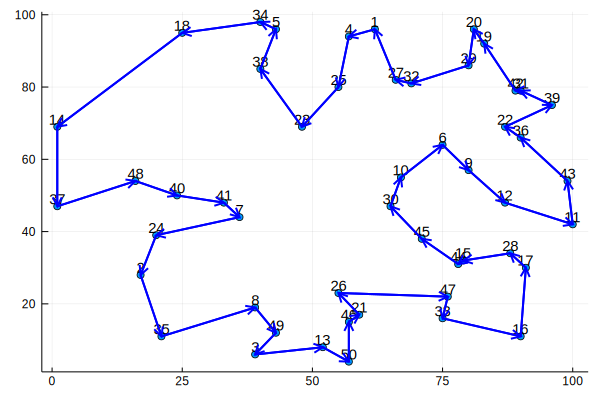

560.9159465468153

In [25]:
resuelveDFZfraccional("i50.txt")

# Comentario Final

Es posible interactuar con el solver mediante callbacks nuevamente para que en cada nodo de BnB, el solver también agregue cortes generados por el usuario (como los encontrados mediante mincut). En la actualidad, los algoritmos más veloces para TSP realizan esto.